# Supervised sentiment: overview of the Stanford Sentiment Treebank

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2022"

## Contents

1. [Overview of this unit](#Overview-of-this-unit)
1. [Set-up](#Set-up)
1. [Data readers](#Data-readers)
    1. [Train split](#Train-split)
    1. [Dev and test splits](#Dev-and-test-splits)
1. [Tokenization](#Tokenization)

## Overview of this unit

We have a few inter-related goals for this unit:

* Provide a basic introduction to supervised learning in the context of a problem that has long been central to academic research and industry applications: __sentiment analysis__.

* Explore and evaluate a diverse array of methods for modeling sentiment:
  * Hand-built feature functions with (mostly linear) classifiers
  * Dense feature representations derived from VSMs as we built them in the previous unit
  * Recurrent neural networks (RNNs)
  
* Begin discussing and implementing responsible methods for __hyperparameter optimization__ and __classifier assessment and comparison__.

The unit is built around the [Stanford Sentiment Treebank (SST)](http://nlp.stanford.edu/sentiment/), a widely-used resource for evaluating supervised NLU models, and one that provides rich linguistic representations.

## Set-up

*  Make sure your environment includes all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u).

* If you haven't already, download [the course data](http://web.stanford.edu/class/cs224u/data/data.tgz), unpack it, and place it in the directory containing the course repository – the same directory as this notebook. (If you want to put it somewhere else, change `SST_HOME` below.)

In [1]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
import os
import pandas as pd

import sst

In [2]:
SST_HOME = os.path.join('data', 'sentiment')

## Data readers

Our SST distribution is the ternary version of the problem (SST-3). It consists of train/dev/test files with the following columns:

1. `example_id`: a string with the format 'N-S' where N is the example number and S is the index for the subtree in example N. Both N and S are five-digit numbers with 0-padding.
2. `sentence`: a string giving the example sentence.
3. `label`: a string giving the label: `'positive'`, `'negative'`, or `'neutral'`. This value is derived from the original SST by mapping labels 0 and 1 to `'negative'`, label 2 to `'neutral'`, and labels 3 and 4 to `'positive'`.
4. `is_subtree`: the integer `1` if the example is a (proper) subtree, else `0`. This affects only the train file. Our dev and test splits contain no subtrees – full examples only – and hence `is_subtree` is always `0` for them.

### Train split

When reading in the train split, you have a few options. 

#### Root-only formulation

The default will include only full examples and retain duplicate examples:

In [3]:
train_df = sst.train_reader(SST_HOME)

In [7]:
train_df.sample(3, random_state=1).to_dict(orient="records")

[{'example_id': '04162-00001',
  'sentence': "One can only assume that the jury who bestowed star Hoffman 's brother Gordy with the Waldo Salt Screenwriting award at 2002 's Sundance Festival were honoring an attempt to do something different over actually pulling it off",
  'label': 'negative',
  'is_subtree': 0},
 {'example_id': '05626-00001',
  'sentence': "Comedy troupe Broken Lizard 's first movie is very funny but too concerned with giving us a plot .",
  'label': 'neutral',
  'is_subtree': 0},
 {'example_id': '02940-00001',
  'sentence': "Imagine O. Henry 's The Gift of the Magi relocated to the scuzzy underbelly of NYC 's drug scene .",
  'label': 'negative',
  'is_subtree': 0}]

In [8]:
train_df.shape[0]

8544

This yields the following label distribution:

In [9]:
train_df.label.value_counts()

label
positive    3610
negative    3310
neutral     1624
Name: count, dtype: int64

You might want to remove the duplicate examples:

In [10]:
dup_train_df = sst.train_reader(SST_HOME, dedup=True)

In [11]:
dup_train_df.shape[0]

8534

This removes only ten examples for this setting so it is unlikely to be a significant choice.

Our CSV-based distribution should make it easy to do basic analysis of the dataset to inform system development. 

Here's a look at the distribution of examples by length in characters:

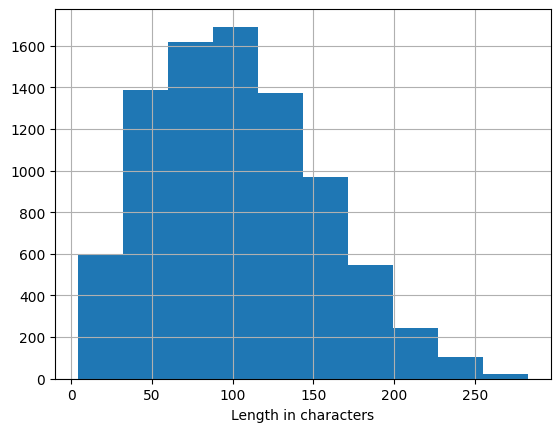

In [14]:
_ = train_df.sentence.str.len().hist().set_xlabel("Length in characters")

And by word count, assuming a very simple tokenization strategy:

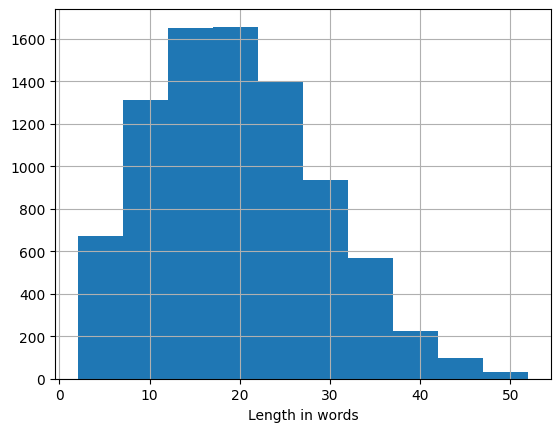

In [15]:
train_df['word_count'] = train_df.sentence.str.split().apply(len)

_ = train_df['word_count'].hist().set_xlabel("Length in words")

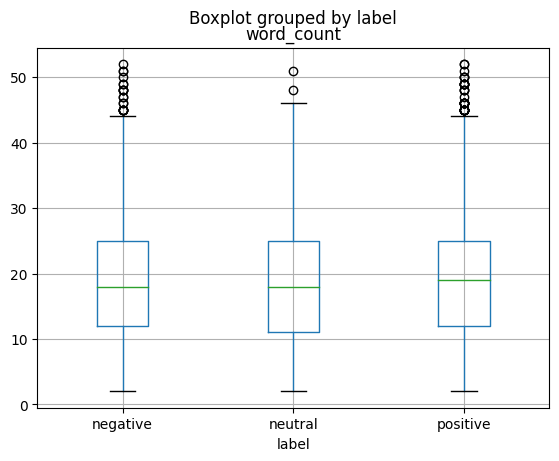

In [16]:
_ = train_df.boxplot("word_count", by="label")

#### Including subtrees

Much of the special interest of the SST is that it includes labels, not just for full examples, but also for all the constituent words and phrases in those examples. You might also want to try training on this expanded dataset. It's much larger and so experiments will be more costly in terms of time and compute resources, but it could be worth it.

In [32]:
subtree_train_df = sst.train_reader(SST_HOME, include_subtrees=True)

subtree_train_df = subtree_train_df[~subtree_train_df.sentence.isna()]

In [33]:
subtree_train_df.shape[0]

318573

In [34]:
subtree_train_df.head()

,example_id,sentence,label,is_subtree
0,00001-00001,The Rock is destined to be the 21st Century 's...,positive,0
1,00001-00002,The Rock,neutral,1
2,00001-00003,The,neutral,1
3,00001-00004,Rock,neutral,1
4,00001-00005,is destined to be the 21st Century 's new `` C...,positive,1


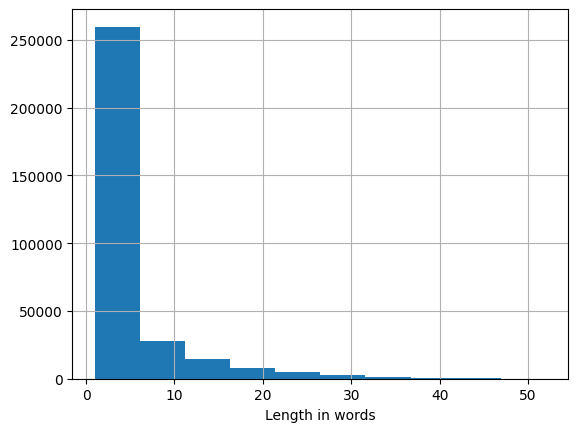

In [35]:
subtree_train_df['word_count'] = subtree_train_df.sentence.str.split().apply(len)

_ = subtree_train_df['word_count'].hist().set_xlabel("Length in words")

In this setting, removing duplicates has a large effect, since many subtrees are repeated:

In [36]:
subtree_dedup_train_df = sst.train_reader(SST_HOME, include_subtrees=True, dedup=True)

In [37]:
subtree_dedup_train_df.shape

(159273, 4)

Label distribution:

In [38]:
subtree_dedup_train_df.label.value_counts()

label
neutral     81657
positive    42672
negative    34944
Name: count, dtype: int64

### Dev and test splits

For the dev and test splits, we include only the root-level examples, and we do not deduplicate to remain aligned with the original paper. (The dev set has one repeated example, and the test set has none.)

In [39]:
dev_df = sst.dev_reader(SST_HOME)

In [40]:
dev_df.shape

(1101, 4)

Label distribution:

In [41]:
dev_df.label.value_counts()

label
positive    444
negative    428
neutral     229
Name: count, dtype: int64

There is an associated `sst.test_reader(SST_HOME)` with 2,210 (root-only) examples and no duplicates. As always in our field, you should use the test set only at the very end of your system development, and you should never, ever develop a system on the basis of test-set scores. 

In a similar vein, you should use the dev set only very sparingly. This will give you a clearer picture of how you will ultimately do on test; over-use of a dev set can lead to over-fitting on that particular dataset with a resulting loss of performance at test time.

In the homework and associated bake-off for this course, we will introduce a second dev/test pair involving sentences about restaurants. The goal there is to have a fresh test set, and to push you to develop a system that works both for the SST movie domain and this new domain.

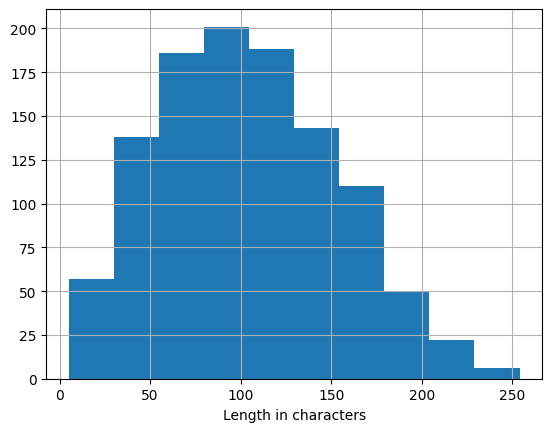

In [43]:
_ = dev_df.sentence.str.len().hist().set_xlabel("Length in characters")

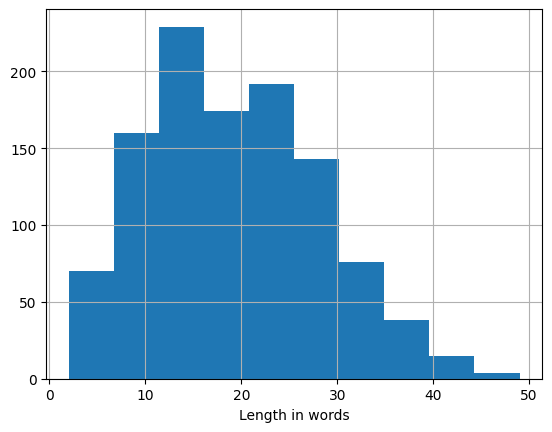

In [44]:
dev_df['word_count'] = dev_df.sentence.str.split().apply(len)

_ = dev_df['word_count'].hist().set_xlabel("Length in words")

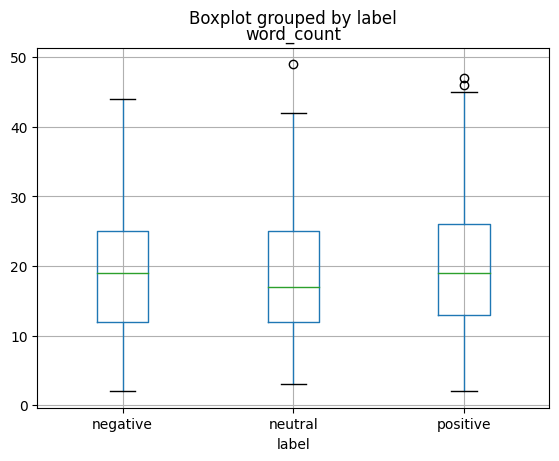

In [45]:
_ = dev_df.boxplot("word_count", by="label")

## Tokenization

The SST began as a collection of sentences from [Rotten Tomatoes](https://www.rottentomatoes.com/) that were released as a corpus by [Pang and Lee 2004](https://doi.org/10.3115/1218955.1218990). The data were parsed as part of the SST project, and we are now releasing them in a flat format similar to what one sees in benchmarks like [GLUE](https://gluebenchmark.com). Along this journey, the sentences have acquired a tokenization scheme that is reminiscent of what one sees in standard [Penn Treenbank](https://catalog.ldc.upenn.edu/docs/LDC95T7/cl93.html) formats, with some additional quirks. This makes the tokens different in sigificant respects from what one sees in most standard English texts:

In [46]:
ex = train_df.iloc[0].sentence

ex

"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."

One can address some of this using the NLTK `TreebankWordDetokenizer`:

In [47]:
detokenizer = TreebankWordDetokenizer()

In [48]:
def detokenize(s):
    return detokenizer.detokenize(s.split())

In [49]:
detokenize(ex)

'The Rock is destined to be the 21st Century\'s new "Conan" and that he\'s going to make a splash even greater than Arnold Schwarzenegger, Jean-Claud Van Damme or Steven Segal.'

As you can see, there is additional clean-up one could do, but this is a start.

Another option would be to go in the reverse – for outside data, one could try to bring it into the SST format:

In [50]:
tokenizer = TreebankWordTokenizer()

In [51]:
def treebank_tokenize(s):
    return tokenizer.tokenize(s)

In [52]:
treebank_tokenize("The Rock isn't the new ``Conan'' – he's this generation's Olivier!")

['The',
 'Rock',
 'is',
 "n't",
 'the',
 'new',
 '``',
 'Conan',
 "''",
 '–',
 'he',
 "'s",
 'this',
 'generation',
 "'s",
 'Olivier',
 '!']